2025-03-15 16:46:40.294797: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


2025-03-15 16:46:41.766860: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Unique values in mask (Sample 1): [0 1]
Class at selected location (Sample 1): 1
Background Class (Sample 1): 0
Unique values in mask (Sample 2): [0 1]
Class at selected location (Sample 2): 0
Background Class (Sample 2): 1


2025-03-15 16:46:42.064507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


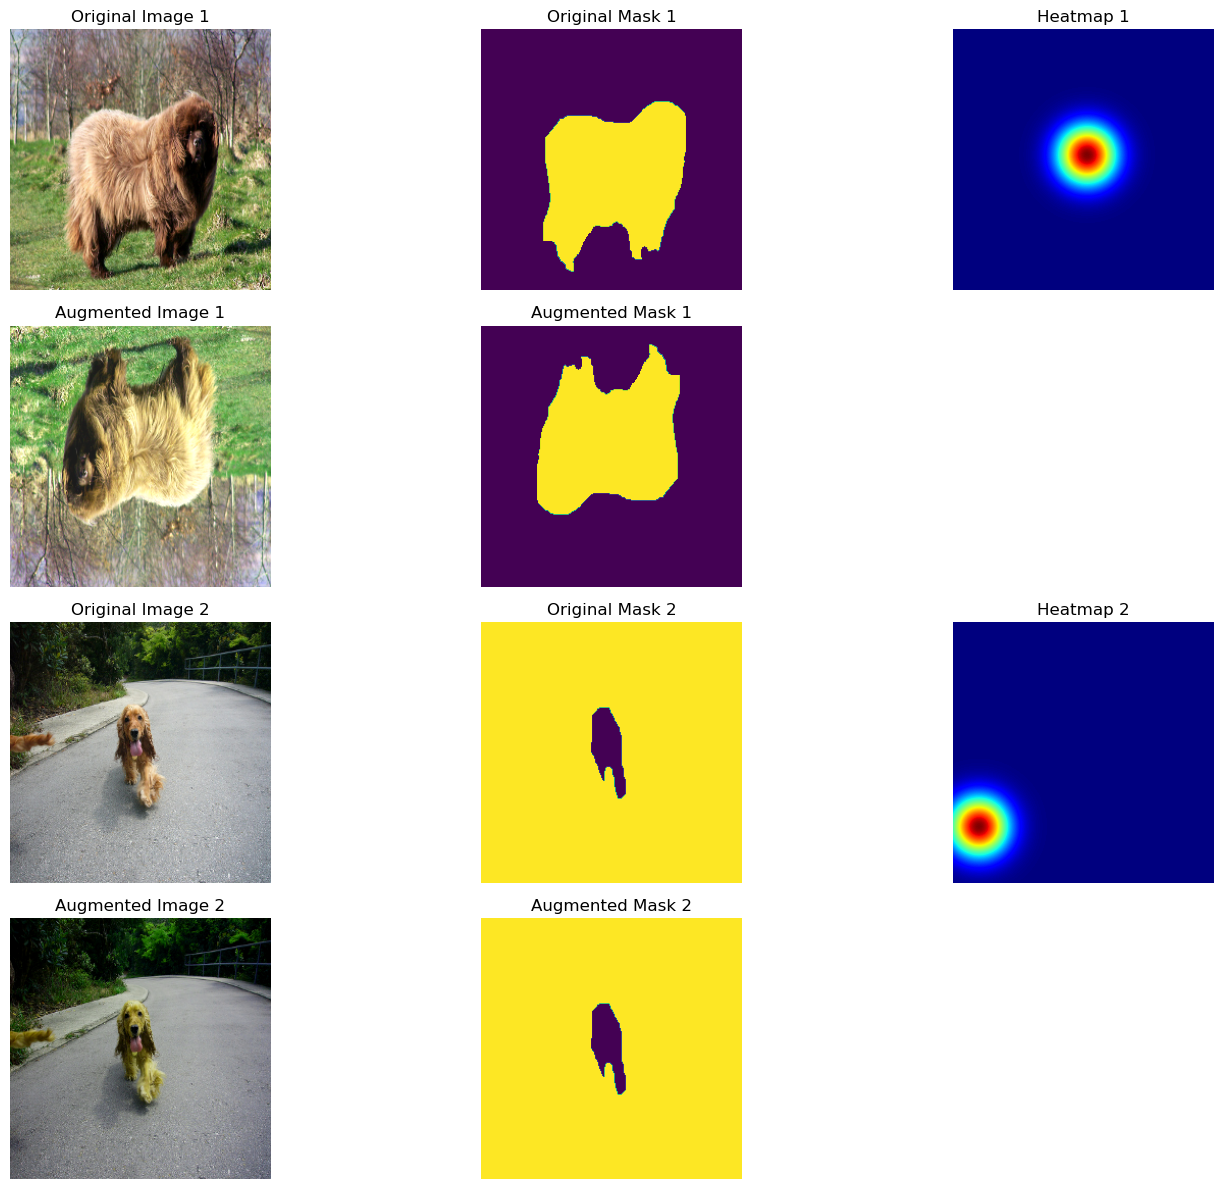

✅ Augmented images saved at: output_images/augmented_dataset_visualization.png


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from data_loading import OxfordPetDataset
import numpy as np
import os

# Define the augmentation function
def augment_image_and_mask(image, mask):
    # Convert mask to float32 to match image data type
    mask = tf.cast(mask, tf.float32)
    
    # Stack image and mask together to ensure the same augmentation is applied
    combined = tf.concat([image, mask], axis=-1)
    
    # Apply geometric augmentations
    combined = tf.image.random_flip_left_right(combined)
    combined = tf.image.random_flip_up_down(combined)
    combined = tf.image.random_brightness(combined, max_delta=0.2)
    combined = tf.image.random_contrast(combined, lower=0.8, upper=1.2)

    # Separate image and mask after augmentation
    augmented_image = combined[:, :, :image.shape[-1]]
    augmented_mask = combined[:, :, image.shape[-1]:]

    # Apply color augmentations to the image only
    augmented_image = tf.image.random_hue(augmented_image, max_delta=0.2)
    augmented_image = tf.image.random_saturation(augmented_image, lower=0.8, upper=1.2)

    return augmented_image, augmented_mask

# Function to determine correct background class
def determine_background_class(mask, location):
    x, y = location  # Extract coordinates
    region_class = mask[x, y]  # Get class at the selected location

    if region_class in [1, 2]:  # Cat or Dog
        background_class = 0  # Background should be 0
    else:
        background_class = 1  # Background should be 1

    return background_class

# Ensure output directory exists
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

# Load the dataset (assuming OxfordPetDataset is defined elsewhere)
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)

dataset.mask_prep()
dataset.heatmaps()

# Assign dataset variables
train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

# Display and save two examples with augmentation
plt.figure(figsize=(15, 12))

for i, example in enumerate(train.take(2)):  # Take two samples
    image = example['image'].numpy()  # Convert tensor to numpy
    mask = example['segmentation_mask'].numpy().squeeze()  # Remove extra dimension
    original_mask = example['original_mask'].numpy().squeeze()
    location = example['location'].numpy()  # Convert location tensor to numpy
    
    # Separate heatmap from the image+heatmap tensor
    image_heatmap = example['image+heatmap'].numpy()
    heatmap = image_heatmap[:, :, 3]  # Extract heatmap channel
    
    # Ensure the image tensor has at least three dimensions
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    
    # Ensure the mask tensor has at least three dimensions
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)
    
    # Determine the correct background class
    background_class = determine_background_class(original_mask, location)
    
    print(f"Unique values in mask (Sample {i+1}):", np.unique(mask))
    print(f"Class at selected location (Sample {i+1}):", original_mask[location[0], location[1]])
    print(f"Background Class (Sample {i+1}):", background_class)

    # Apply augmentation to both image and mask ensuring alignment
    augmented_image, augmented_mask = augment_image_and_mask(tf.convert_to_tensor(image), tf.convert_to_tensor(mask))
    
    # Convert augmented tensors back to numpy arrays for visualization
    augmented_image_np = augmented_image.numpy()
    augmented_mask_np = augmented_mask.numpy().squeeze()

    # Plot original images and masks
    plt.subplot(4, 3, i * 6 + 1)
    plt.imshow(image.squeeze())
    plt.title(f"Original Image {i+1}")
    plt.axis("off")

    plt.subplot(4, 3, i * 6 + 2)
    plt.imshow(mask.squeeze())
    plt.title(f"Original Mask {i+1}")
    plt.axis("off")

    plt.subplot(4, 3, i * 6 + 3)
    plt.imshow(heatmap, cmap="jet")
    plt.title(f"Heatmap {i+1}")
    plt.axis("off")

    # Plot augmented images and masks
    plt.subplot(4, 3, i * 6 + 4)
    plt.imshow(augmented_image_np.squeeze())
    plt.title(f"Augmented Image {i+1}")
    plt.axis("off")

    plt.subplot(4, 3, i * 6 + 5)
    plt.imshow(augmented_mask_np.squeeze())
    plt.title(f"Augmented Mask {i+1}")
    plt.axis("off")

# Save the visualization
save_path = os.path.join(output_dir, "augmented_dataset_visualization.png")
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Augmented images saved at: {save_path}")